### 1. Compare reanalysis data, model data and/or AWS data

In [20]:
import xarray as xr 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import scipy.stats as ss
import copy
from scipy.stats import gaussian_kde

In [21]:
# plot_type = 'hist'
# ds_AWS = xr.open_dataset('~/research/Output/EB/Gulkana_2025_01_31_climate_B.nc')
# ds_MERRA = xr.open_dataset('~/research/Output/EB/Gulkana_2025_01_31_MERRA_climate_B.nc')
# fig,axes = plt.subplots(3,2,gridspec_kw={'hspace':0.8,'wspace':0.3},figsize=(6,4))
# axes = axes.flatten()
# labels = {'temp':'Air temperature ($^{\circ}$C)',
#           'rh':'Relative humidity (%)',
#           'wind':'Wind speed (m/s)',
#           'sp':'Surface pressure (hPa)',
#           'SWin':'Incoming shortwave (W/m$^2$)',
#           'LWin':'Incoming longwave (W/m$^2$)'}
# for i,var in enumerate(['temp','rh','wind','sp','SWin','LWin']):
#     ax = axes[i]
#     if 'Win' in var:
#         ds_MERRA[var].values /= 3600
#         ds_AWS[var].values /= 3600
#     if var == 'sp':
#         ds_MERRA[var].values /= 100
#         ds_AWS[var].values /= 100
#     if plot_type == 'scatter':
#         ax.scatter(ds_AWS[var],ds_MERRA[var])
#         minval = np.min([ds_AWS[var].values,ds_MERRA[var].values])
#         maxval = np.max([ds_AWS[var].values,ds_MERRA[var].values])
#         ax.plot([minval,maxval],[minval,maxval],color='k')
#         ax.set_ylim([minval,maxval])
#         ax.set_xlim([minval,maxval])
#         fig.supylabel('MERRA-2',x=0.05,fontsize=12)
#         fig.supxlabel('AWS',y=0,fontsize=12)
#     elif plot_type == 'hist':
#         diff = ds_MERRA[var] - ds_AWS[var]
#         # ax.hist(diff)
#         counts,bins = np.histogram(ds_MERRA[var])
#         ax.hist(ds_MERRA[var],bins=bins,color='k',label='MERRA-2')
#         ax.hist(ds_AWS[var],bins=bins,alpha=0.8,label='AWS')
#         ax.axvline(np.mean(ds_MERRA[var]),color='k')
#         ax.axvline(np.mean(ds_AWS[var]))
#         fig.supylabel('Count')
#     ax.set_title(labels[var],fontsize=10)
# axes[4].legend()
# fig.suptitle('Statistically downscaled climate forcings',y=1.01)
# plt.show()

In [22]:
def bias_adjust(data_AWS,data_MERRA,var,method='LOWESS',bins=None):
    fig,axes = plt.subplots(2,2,figsize=(6,6),gridspec_kw={'hspace':0.3,'wspace':0.3})
    ax,ax1,ax2,ax3 = axes.flatten()
    if var == 'SWin':
        index_not0 = np.where((data_MERRA > 0) & (data_AWS > 0))[0]
        data_AWS = data_AWS[index_not0]
        data_MERRA = data_MERRA[index_not0]

    y = data_AWS/data_MERRA
    x = data_MERRA

    # Filter infinity
    idx_not_inf = np.where(y < 1e10)[0]
    y_data = y[idx_not_inf]
    x_data = x[idx_not_inf]

    if method == 'LOWESS':
        assert bins is not None, 'specify bins for LOWESS regression'
        import statsmodels.api as sm
        lowess_result = sm.nonparametric.lowess(y_data,x_data, frac=0.2)

        # Extract smoothed values
        smoothed_x = lowess_result[:, 0]
        smoothed_y = lowess_result[:, 1]
        ax.plot(smoothed_x, smoothed_y, 'r', label='LOWESS Smoothing')
        ax.set_ylim((np.min(y_data),np.max(smoothed_y)*1.05))

        values = []
        for i in range(1,len(bins)):
            bottom = bins[i-1]
            top = bins[i]
            where = np.where((smoothed_x < top) & (smoothed_x >= bottom))[0]
            values.append(np.mean(smoothed_y[where]))
        ax1.bar(bins[:-1], values, width=np.diff(bins), align='edge',color='red')
        ax1.set_xlabel(f'Binned {var} factor')

        # Perform adjustment
        raw = copy.deepcopy(data_MERRA)
        def piecewise_scale(x,bins=bins,values=values):
            scale = np.ones_like(x)
            for i in range(1,len(bins)):
                where = np.where((x >= bins[i-1]) & (x < bins[i]))[0]
                scale[where] *= values[i-1]
            return scale
        scale = piecewise_scale(raw)
        adj = raw * scale
    elif method == 'exp':
        from scipy.optimize import curve_fit
        def exponential_func(x, a, b):
            return a*np.exp(x*b)
        
        params, _ = curve_fit(exponential_func, x_data, y_data, p0=(80,-2))
        a,b = params
        x_fit = np.linspace(0,15,200)
        y_fit = exponential_func(x_fit, a, b)
        ax.plot(x_fit,y_fit,'r',label='Exponential fit')
        # ax1.scatter(AWS_wind,exponential_func(MERRA_wind, a, b))
        adj = data_MERRA * exponential_func(data_MERRA,a,b)
    elif method == 'quantile':
        import scipy.stats as ss
        # Calculate the CDF of the reanalysis and observed data
        reanalysis_cdf = (ss.rankdata(data_MERRA, method="average") - 1) / (len(data_MERRA) - 1)
        
        # Create a mapping from reanalysis quantiles to observed quantiles
        quantile_map = np.interp(reanalysis_cdf, np.sort(reanalysis_cdf), np.sort(data_AWS))
        
        # Adjust the reanalysis data using the quantile mapping
        adj = np.interp(data_MERRA, np.sort(data_MERRA), quantile_map)
        ax2.scatter(data_AWS, adj)

    # Plot original data and smoothed curve
    kde = gaussian_kde([x_data, y_data])
    density = kde(np.vstack([x_data, y_data]))
    ax.scatter(x_data,y_data,label='Data',c=density, cmap=plt.cm.magma)
    ax.legend()
    ax.set_xlabel(f'MERRA-2 {var}')
    ax.set_ylabel(f'AWS {var} / MERRA-2 {var}')
    ax.set_ylim(0)

    # ax2.scatter(AWS_wind,raw,label='Unadjusted MERRA-2')
    kde = gaussian_kde([data_AWS, adj])
    density = kde(np.vstack([data_AWS, adj]))
    ax2.scatter(data_AWS,adj,c=density,cmap=plt.cm.magma,label='Adjusted MERRA-2')
    ax2.set_xlabel(f'AWS {var}')
    ax2.set_ylabel(f'Adjusted MERRA-2 {var}')
    if method == 'LOWESS':
        ax2.plot([0,bins[-1]],[0,bins[-1]],'k--')
    ax.set_ylim((0,5))
    data_min = np.min([adj,data_AWS])
    data_max = np.max([adj,data_AWS])
    ax2.set_xlim(data_min,data_max)
    ax2.set_ylim(data_min,data_max)
    _,hist_bins = np.histogram(data_MERRA)
    ax3.hist(data_MERRA,histtype='step',label='Raw MERRA',linestyle='--')
    ax3.hist(adj,bins=hist_bins,histtype='step',label='Adj. MERRA')
    ax3.hist(data_AWS,bins=hist_bins,histtype='step',label='AWS')
    ax3.axvline(np.mean(data_MERRA),linestyle='--')
    ax3.axvline(np.mean(adj),color=plt.cm.tab10(1))
    ax3.axvline(np.mean(data_AWS),color=plt.cm.tab10(2))
    ax3.set_xlabel(f'Distribution of {var}')
    ax3.legend()
    plt.show()
    if method == 'LOWESS':
        return bins, values
    elif method == 'exp':
        return a,b
    elif method == 'quantile':
        return np.sort(data_MERRA), quantile_map

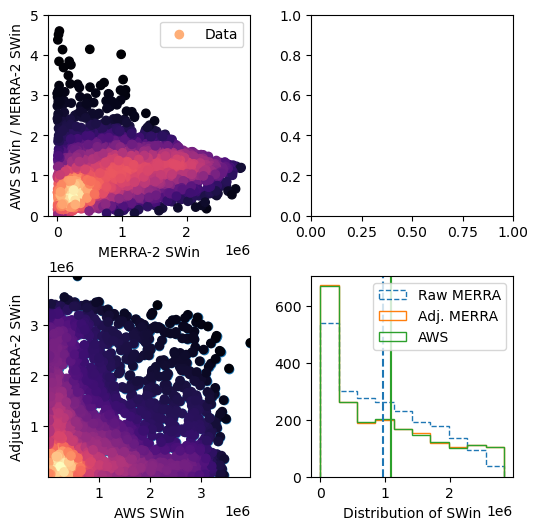

In [23]:
ds_AWS = xr.open_dataset('~/research/Output/EB/Gulkana_2025_02_03_climate_B.nc')
ds_MERRA = xr.open_dataset('~/research/Output/EB/Gulkana_2025_02_03_MERRA_climate_B.nc')
var = 'SWin'
bins_dict = {'wind':[0,0.5,1,2,15],
             'SWin':[0,0.5e6,1e6,1.5e6,2e6,4e6],
             'LWin':[0.8e6,1e6,1.2e6,1.5e6],
             'temp':[-20,0,20]}
method = 'quantile'
data_AWS = ds_AWS[var].values
data_MERRA = ds_MERRA[var].values
sorted, mapping = bias_adjust(data_AWS,data_MERRA,var,method=method,bins=bins_dict[var])

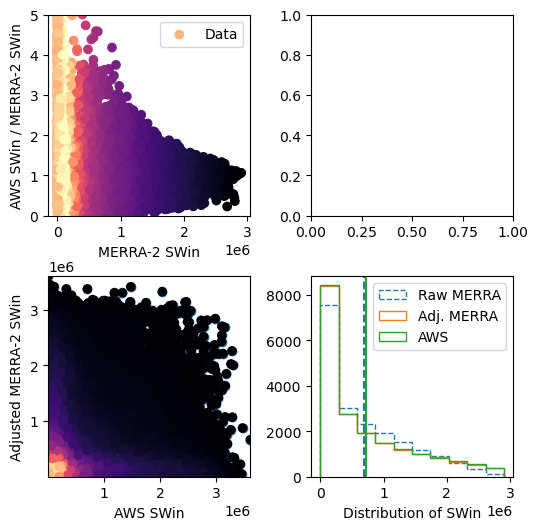

In [29]:
var = 'SWin'
nunatak = pd.read_csv('~/research/climate_data/AWS/gulkana/1725/LVL2/gulkana1725_hourly_LVL2_ALL.csv',index_col=0)
nunatak.index = pd.to_datetime(nunatak.index)
dates = pd.date_range('2017-01-01','2021-01-01',freq='h') + pd.Timedelta(hours=8)
nunatak = nunatak.loc[dates[0]:dates[-1],'ShortwaveIn']
nunatak[np.isnan(nunatak.values)] = 0
nunatak[nunatak < 0] = 0
data_AWS = nunatak.values
ds_MERRA = xr.open_dataarray('~/research/climate_data/MERRA2/SWGDN/MERRA2_SWGDN_60_-150.nc').sel(lat=63.5,lon=-145.625)
data_MERRA = ds_MERRA.interp(time=dates).values
sorted, mapping = bias_adjust(data_AWS*3600,data_MERRA*3600,var,method='quantile')
# df = pd.DataFrame({'sorted':sorted, 'mapping':mapping})
# df.to_csv('../../data/quantile_mapping_SWin.csv')

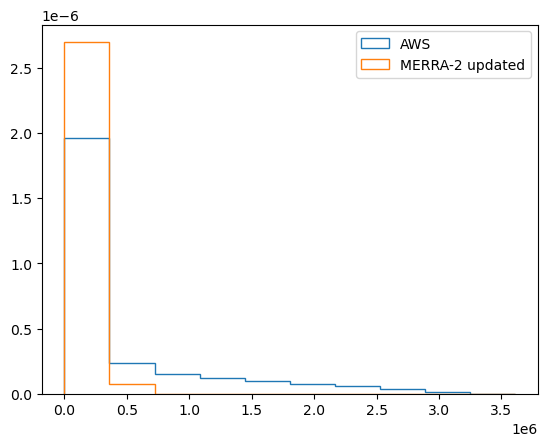

In [31]:
if var == 'wind':
    data_u = xr.open_dataarray('~/research/climate_data/MERRA2/U2M/MERRA2_U2M_60_-150.nc').sel(lat=63.5,lon=-145.625)
    data_v = xr.open_dataarray('~/research/climate_data/MERRA2/V2M/MERRA2_V2M_60_-150.nc').sel(lat=63.5,lon=-145.625)
    data = np.sqrt(np.square(data_u.values) + np.square(data_v.values))
elif var == 'SWin':
    data = xr.open_dataarray('~/research/climate_data/MERRA2/SWGDN/MERRA2_SWGDN_60_-150.nc').sel(lat=63.5,lon=-145.625)
data_MERRA = ds_MERRA.values*3600
data_AWS *= 3600

if method == 'quantile':
    adj = np.interp(data, sorted, mapping)
if method == 'LOWESS':
    bias_df = pd.read_csv(f'~/research/PyGEM-EB/data/binned_{var}.csv')
    bins = np.append(np.zeros(1), bias_df['bins'])
    scale = np.ones_like(data)
    for i in range(1,len(bins)):
        index = np.where((data >= bins[i-1]) & (data < bins[i]))[0]
        scale[index] = bias_df['factor'][i-1]
    adj = data * scale
counts,bins = np.histogram(data_AWS)
plt.hist(data_AWS,bins=bins,density=True,histtype='step',label='AWS')
plt.hist(adj,bins=bins,density=True,histtype='step',label='MERRA-2 updated')
plt.legend()
plt.show()

In [23]:
# INPUTS
var = 'temp'      # Variable to compare
units = '$^{\circ}$C'
model = 'MERRA2'
start = pd.to_datetime('2024-04-20 00:00')
end = pd.to_datetime('2024-08-20 00:00')
res = 'd'
resample = True         # resample to res or just sample at that resolution
plothour = 14           # hour of day to plot if not resampling
timezone = pd.Timedelta(hours=-8)

# necessary initialization
units_checked = False
all_vars = {'temp':{'MERRA2':'T2M','ERA5':'t2m'},
            'tp':{'MERRA2':'PRECTOTCORR','ERA5':'tp'},
            'rh':{'MERRA2':'RH2M','ERA5':'rh'},
            'SWin':{'MERRA2':'SWGDN','ERA5':'ssrd'},
            'LWin':{'MERRA2':'LWGAB','ERA5':'strd'},
            'uwind':{'MERRA2':'U2M','ERA5':'u10'},
            'vwind':{'MERRA2':'V2M','ERA5':'v10'},
            'sp':{'MERRA2':'PS','ERA5':'sp'},
            'tcc':{'MERRA2':'CLDTOT','ERA5':'tcc'},
            'bcwet':{'MERRA2':'BCWT002'},'bcdry':{'MERRA2':'BCDP002'},
            'dustwet':{'MERRA2':'DUWT002'},'dustdry':{'MERRA2':'DUDP002'}}
varlabels = {'temp':'air temperature','tp':'precipitation',
             'rh':'relative humidity','SWin':'incoming shortwave flux',
            'LWin':'incoming longwave flux','wind':'wind speed',
            'sp':'surface pressure','tcc':'total cloud cover'}

In [24]:
# FILEPATHS
fp_clim = '/home/claire/research/climate_data/'
fp_MERRA2 = os.path.join(fp_clim,'MERRA2/VAR/MERRA2_VAR_LAT_LON.nc')
fp_ERA5 = os.path.join(fp_clim,'ERA5/ERA5_hourly/ERA5_VAR_hourly.nc')
fp_AWS = os.path.join(fp_clim,'AWS/Preprocessed/CLAWS_2024.csv') # 'AWS/Preprocessed/south/south2280_2008.csv'
# 'AWS/Gulkana/LVL2/gulkana1480_hourly_LVL2.csv'
list_RGI = os.listdir('/home/claire/research/RGI/rgi60/00_rgi60_attribs/')

In [25]:
# GLACIER COORDINATES
# fill out glac_no for cenlat/lon and glacier_name for getting AWS data
glac_no = '01.00570' # '01.16195' 
glacier_name = 'Gulkana' # 'South'
# glac_no = '15.03733'
# glacier_name = 'Khumbu'
region = glac_no[:2]
for file in list_RGI:
    if region in file:
        fp_RGI = '/home/claire/research/RGI/rgi60/00_rgi60_attribs/' + file
# extract lat/lon of glacier
glacier_table = pd.read_csv(fp_RGI)
glacier_table = glacier_table.loc[glacier_table['RGIId'] == 'RGI60-'+glac_no]
cenlat = glacier_table['CenLat'].to_numpy()[0]
cenlon = glacier_table['CenLon'].to_numpy()[0]

In [26]:
# GET MODEL DATA
if model in ['MERRA2']:
    start_M = start + pd.Timedelta(minutes=30) - timezone
    end_M = end + pd.Timedelta(minutes=30) - timezone
    file_lat = str(int(np.floor(cenlat/10)*10))
    file_lon = str(int(np.floor(cenlon/10)*10))
    fn_MERRA2 = fp_MERRA2.replace('LAT',file_lat).replace('LON',file_lon)
    if var != 'wind':
        fn_MERRA2 = fn_MERRA2.replace('VAR',all_vars[var]['MERRA2'])
        ds = xr.open_dataset(fn_MERRA2)
    else:
        fn_MERRA2_u = fn_MERRA2.replace('VAR',all_vars['uwind']['MERRA2'])
        fn_MERRA2_v = fn_MERRA2.replace('VAR',all_vars['vwind']['MERRA2'])
        dsu = xr.open_dataset(fn_MERRA2_u).sel(time=pd.date_range(start_M,end_M,freq='h'))
        dsv = xr.open_dataset(fn_MERRA2_v).sel(time=pd.date_range(start_M,end_M,freq='h'))
        ds = dsu.copy(deep=True)
        uwind = dsu.U2M.values
        vwind = dsv.V2M.values
        ds.U2M.values = np.sqrt(np.power(uwind,2)+np.power(vwind,2))
        ds = ds.rename({'U2M':'wind'})
    ds = ds.sel(time=pd.date_range(start_M,end_M,freq='h'))
    ds = ds.interp(time=pd.date_range(start-timezone,end-timezone,freq='h'))
    ds.coords['time'] = pd.date_range(start,end,freq='h')
    eds = xr.open_dataset('~/research/climate_data/MERRA2/MERRA2constants.nc4')
    latname = 'lat'
    lonname = 'lon'
    elevname = 'PHIS'

elif model in ['ERA5']:
    fn_ERA5 = fp_ERA5.replace('VAR',var)
    ds = xr.open_dataset(fn_ERA5)
    eds = xr.open_dataset('~/research/climate_data/ERA5/ERA5_hourly/ERA5_geopotential.nc')
    latname = 'latitude'
    lonname = 'longitude'
    elevname = 'z'

# get latitude and longitude of nearest point
datalat = ds.coords[latname][:].values
datalon = ds.coords[lonname][:].values
lat_nearidx = np.abs(cenlat - datalat).argmin()
lon_nearidx = np.abs(cenlon - datalon).argmin()
lat = datalat[lat_nearidx]
lon = datalon[lon_nearidx]

if model == 'ERA5':
    lat = lat.round(2)
    lon = lon.round(2)
    if var == 'tcc':
        lat = lat.round(1)
        lon = lon.round(1)

# select dataset by closest lat/lon to glacier center
ds = ds.sel({latname:lat,lonname:lon}).drop_vars([latname,lonname])
eds = eds.sel({latname:lat,lonname:lon})
elev = eds[elevname].to_numpy()[0] / 9.81
ds_model = ds.copy(deep=True)

In [27]:
# GET AWS DATA
df_AWS = pd.read_csv(fp_AWS,index_col=0)
df_AWS.index = pd.to_datetime(df_AWS.index)
if 'z' not in df_AWS.columns:
    print('FILL Z OUT MANUALLy')
    AWS_elev = 1480 
else:
    AWS_elev = df_AWS.iloc[0]['z']

if 'site_temp_USGS' in df_AWS.columns:
    df_AWS = df_AWS.rename(columns={'site_temp_USGS':'temp'})
if 'Precip_Weighing_Incremental' in df_AWS.columns:
    df_AWS.fillna({'Precip_Weighing_Incremental':df_AWS['Precip_Stage_Incremental']*1.48},inplace=True)
    df_AWS = df_AWS.rename(columns={'Precip_Weighing_Incremental':'tp'})
if 'ShortwaveIn' in df_AWS.columns:
    df_AWS = df_AWS.rename(columns={'ShortwaveIn':'SWin'})

if start >= df_AWS.index[0] and end <= df_AWS.index[len(df_AWS)-1]:
    df_AWS = df_AWS.loc[pd.date_range(start,end,freq='h')]
else:
    start = pd.to_datetime(df_AWS.index[0])
    end = pd.to_datetime(df_AWS.index[len(df_AWS)-1])
# 

In [28]:
# CHECK UNITS AND ADJUST TO ELEVATION
if not units_checked:
    if var == 'tp':
        df_AWS = df_AWS['tp'].to_frame() / 1000
        ds_model = ds_model * 3600 / 1000
    elif var == 'temp':
        df_AWS = df_AWS[var].to_frame()
        ds_model = ds_model - 273.15
        print(f'Adjusting to {AWS_elev - elev:.1f} m elevation change from geopotential to the AWS elevation')
        print(f'(temperature change of {-0.0065*(AWS_elev - elev) :.3f} C)')
        ds_model = ds_model - 0.0065*(AWS_elev - elev)
    elif var == 'sp':
        temp_gp = df_AWS['temp'] + 0.0065*(AWS_elev - elev) - 273.15
        temp_AWS = df_AWS['temp'] - 273.15
        df_AWS['sp'] = df_AWS['sp']*(temp_gp / temp_AWS)**(9.81*0.0289644/8.314/0.0065)
        df_AWS = df_AWS[var].to_frame()
    elif var in ['SWin','LWin']:
        df_AWS /= 3600

Adjusting to 449.2 m elevation change from geopotential to the AWS elevation
(temperature change of -2.920 C)


In [29]:
if var == 'temp':
    ds_model = ds_model * 0.72801 + 2.234

In [30]:
 # *np.exp(-9.81*0.0289644*(elev - AWS_elev)/8.314/temp_AWS)

Plot the mean over the period of each hour of day (good quality control check)

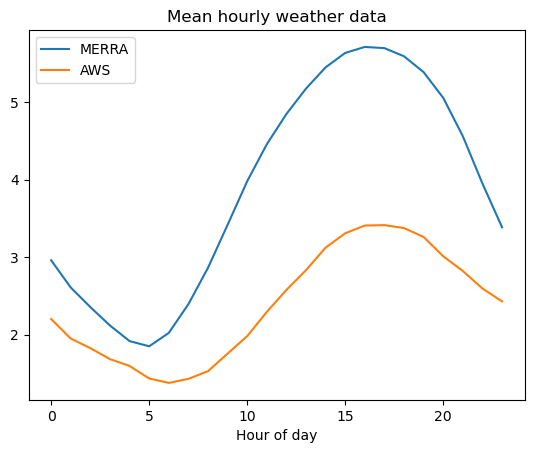

In [31]:
ds_model['hour'] = (['time'],pd.to_datetime(ds_model['time'].values).hour)
if isinstance(df_AWS,pd.DataFrame):
    df_AWS = df_AWS.assign(hour=pd.to_datetime(df_AWS.index).hour)
else:
    df_AWS = df_AWS.to_frame().assign(hour=pd.to_datetime(df_AWS.index).hour)
hourly_model = []
hourly_AWS = []
for hour in np.arange(24):
    ds_hour = ds_model.where(ds_model['hour'] == hour,drop=True)
    if var != 'wind':
        vardata = ds_hour[all_vars[var]['MERRA2']].values
    else:
        vardata = ds_hour['wind'].values
    hourly_mean = np.mean(vardata[~np.isnan(vardata)])
    hourly_model.append(hourly_mean)

    df_hour = df_AWS.loc[df_AWS['hour'] == hour]
    vardata = df_hour[var].values
    hourly_mean = np.mean(vardata[~np.isnan(vardata)])
    hourly_AWS.append(hourly_mean)
plt.plot(np.arange(24),hourly_model,label='MERRA')
plt.plot(np.arange(24),hourly_AWS,label='AWS')
plt.legend()
plt.ylabel('')
plt.xlabel('Hour of day')
plt.title('Mean hourly weather data')
plt.show()

Resample or select the data with the proper resolution

In [33]:
# RESAMPLE
if resample:
    if var in ['tp']:
        df_AWS = df_AWS.resample(res).sum()
        ds_model = ds_model.resample(time=res).sum()
    if var in ['bcwet','bcdry','dustwet','dustdry']:
        ds_model = ds_model.resample(time=res).sum() * 3600
    else:
        df_AWS = df_AWS.resample(res).mean()
        ds_model = ds_model.resample(time=res).mean()
        if len(df_AWS.index) != len(ds_model.coords['time']):
            df_AWS = df_AWS.iloc[1:]
else:
    starthour = str((start+pd.Timedelta(days=1)).date()) + f' {plothour}:00'
    endhour = str((end-pd.Timedelta(days=1)).date()) + f' {plothour}:00'
    timehour = pd.date_range(starthour,endhour,freq='d')
    ds_model = ds_model.sel(time=timehour)
    df_AWS = df_AWS.loc[timehour]

Perform two-sided t-test to determine if the means are significantly different

In [34]:
if var != 'wind':
    plot_model = ds_model[all_vars[var][model]].values
else:
    plot_model = ds_model['wind'].values
df_AWS = df_AWS.fillna(0)
plot_AWS = df_AWS[var].to_numpy() #['Precip_Weighing_Incremental'].to_numpy()
plot_model[np.isnan(plot_model)] = np.nanmean(plot_model)
if var == 'tp':
    plot_model = np.cumsum(plot_model)
    plot_AWS = np.cumsum(plot_AWS)
ttest = ss.ttest_rel(plot_AWS,plot_model,alternative='two-sided')
p = ttest.pvalue
print('Means:')
print('  ttest pvalue:', p)
if p < 0.05:
    result = 'significantly different'
else:
    result = 'not different'
print('     ',result)

Means:
  ttest pvalue: 2.5038505961139535e-16
      significantly different


Plot comparison

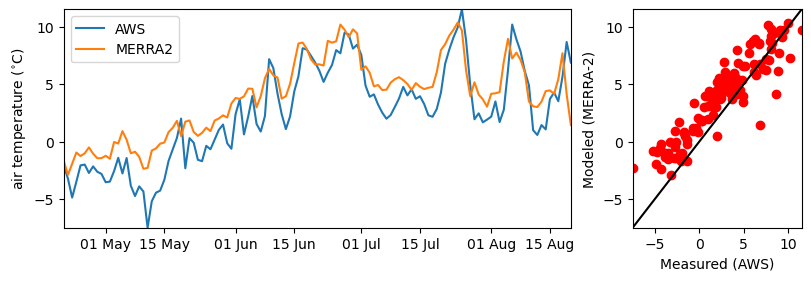

In [35]:
fig,[ax1,ax2] = plt.subplots(1,2,width_ratios=[3,1],figsize=(8,2.7),layout='constrained')
ax1.plot(df_AWS.index,plot_AWS,label='AWS')
ax1.plot(ds_model['time'],plot_model,label=model)

ax1.legend()
ax2.scatter(plot_AWS,plot_model,label='AWS',c='r')
maxval = max(np.max(plot_AWS),np.max(plot_model))
minval = min(np.min(plot_AWS),np.min(plot_model))
ax2.plot([minval,maxval],[minval,maxval],c='black')
label = varlabels[var]
ax1.set_ylabel(f'{label} ({units})')
ax2.set_xlabel('Measured (AWS)')
ax2.set_ylabel('Modeled (MERRA-2)')
date_form = mpl.dates.DateFormatter('%d %b')
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim([start+pd.Timedelta(days=1),end])
ax1.set_ylim([minval,maxval])
ax2.set_xticks(ax2.get_yticks())
ax2.set_xlim([minval,maxval])
ax2.set_ylim([minval,maxval])
# ax1.set_title(f'Hourly {label}',fontsize=10)
# ax2.set_title(f'Two-sided t-test \n $p={p:.3e}$, {result}',fontsize=10)
# fig.suptitle(f'AWS to MERRA-2 {label} comparison on Gulkana Glacier, AK')
plt.savefig(fp_clim + f'MERRA2_AWS_comparison_2024_{var}.png',dpi=200,bbox_inches='tight')
plt.show()

In [269]:
var = 'rh'
units = '%'
varlabels[var]= 'Relative humidity'

### 3. Temperature bias in MERRA-2

In [52]:
def monthly_means(df):
    df['Date'] = pd.to_datetime(df.index)
    df['Month'] = df['Date'].dt.month
    df_monthly = df.groupby('Month').mean()
    return df_monthly

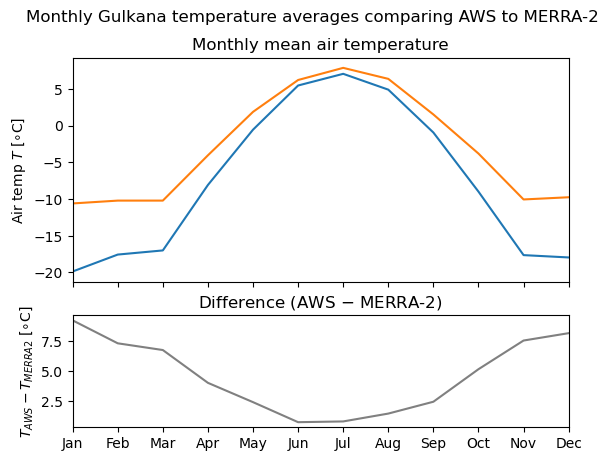

In [57]:
fig,ax = plt.subplots(2,height_ratios=[2,1],sharex=True)
date_range = pd.date_range('2024-01-01','2024-12-31',freq='MS')
monthnames = [date.strftime('%B')[:3] for date in date_range]
df_model = ds_model.to_dataframe().rename(columns={'T2M':'temp'})
monthly_model = monthly_means(df_model)
# df_AWS = df_AWS.to_frame().rename(columns={'site_temp_USGS':'temp'})
monthly_AWS = monthly_means(df_AWS)
diff = df_AWS['temp'] - df_model['temp']
monthly_diff = monthly_means(diff.to_frame())

ax[0].plot(monthnames,monthly_model['temp'],label='MERRA2')
ax[0].plot(monthnames,monthly_AWS['temp'],label='AWS')
ax[0].set_ylabel('Air temp $T$ [$\circ$C]')
ax[0].set_title('Monthly mean air temperature')
ax[1].plot(monthnames,monthly_diff['temp'],color='gray')
ax[1].set_ylabel('$T_{AWS}-T_{MERRA2}$ [$\circ$C]')
ax[1].set_title('Difference (AWS $-$ MERRA-2)')
ax[1].set_xlim(monthnames[0],monthnames[11])
fig.suptitle('Monthly Gulkana temperature averages comparing AWS to MERRA-2')
plt.show()

In [137]:
# monthly_diff['diff'] = monthly_diff['temp']
# monthly_diff['diff'].to_csv('/home/claire/research/PyGEM-EB/pygem_eb/data/Gulkana_MERRA2_temp_diff.csv')

In [26]:
df = pd.read_csv('/home/claire/research/PyGEM-EB/pygem_eb/sample_data/gulkana/Gulkana_MERRA2_temp_bias.csv',index_col=0)
df

,bias
Month,
1,9.105425
2,7.270101
3,6.876635
4,4.119061
5,2.497643
6,0.789153
7,1.081381
8,1.419114
9,2.389362
